# Задание 2: Эксперименты с шириной сети 

## 2.1. Сравнение моделей разной ширины

### Импорт библиотек

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as v2
import time
import matplotlib.pyplot as plt
from collections import defaultdict

### Сама модель

In [3]:
class BaseModelNN(nn.Module):
    def __init__(self, layer_widths):
        super().__init__()
        layers = []
        input_size = 784
        
        for width in layer_widths:
            layers.append(nn.Linear(input_size, width))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            input_size = width
        
        layers.append(nn.Linear(input_size, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

### Функция для обучения и валидации

In [10]:
def train_model(layer_widths, batch_size=128, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform = v2.Compose([
        v2.ToTensor(),
        v2.Normalize((0.1307,), (0.3081,))
    ])
    
    train_set = datasets.MNIST('./data', train=True, download=False, transform=transform)
    val_set = datasets.MNIST('./data', train=False, download=False, transform=transform)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    
    model = BaseModelNN(layer_widths).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    start_time = time.time()
    train_losses = []
    val_accuracies = []

    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                y_pred = model(images)
                _, predicted = torch.max(y_pred.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        train_losses.append(epoch_loss / len(train_loader))
        print(f"Widths: {layer_widths} | Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(train_loader):.4f} | Accuracy: {accuracy:.2f}%")
    
    training_time = time.time() - start_time
    num_params = sum(p.numel() for p in model.parameters())
    
    return {
        "widths": layer_widths,
        "accuracy": val_accuracies[-1],
        "time": training_time,
        "params": num_params,
        "test_acc_history": val_accuracies
    }

### Обучение модели

In [11]:
configurations = {
    "Узкие слои": [64, 32, 16],
    "Средние слои": [256, 128, 64],
    "Широкие слои": [1024, 512, 256],
    "Очень широкие слои": [2048, 1024, 512]
}

results = {}
for name, widths in configurations.items():
    print(f"\n** Конфигурация: {name} {widths}:")
    res = train_model(widths)
    results[name] = res


** Конфигурация: Узкие слои [64, 32, 16]:


C:\miniconda\envs\ml\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Widths: [64, 32, 16] | Epoch 1/10 | Loss: 1.5187 | Accuracy: 81.93%
Widths: [64, 32, 16] | Epoch 2/10 | Loss: 1.0889 | Accuracy: 83.12%
Widths: [64, 32, 16] | Epoch 3/10 | Loss: 0.9851 | Accuracy: 90.90%
Widths: [64, 32, 16] | Epoch 4/10 | Loss: 0.9266 | Accuracy: 90.95%
Widths: [64, 32, 16] | Epoch 5/10 | Loss: 0.8911 | Accuracy: 91.88%
Widths: [64, 32, 16] | Epoch 6/10 | Loss: 0.8617 | Accuracy: 91.84%
Widths: [64, 32, 16] | Epoch 7/10 | Loss: 0.8528 | Accuracy: 91.72%
Widths: [64, 32, 16] | Epoch 8/10 | Loss: 0.8277 | Accuracy: 92.21%
Widths: [64, 32, 16] | Epoch 9/10 | Loss: 0.8200 | Accuracy: 92.36%
Widths: [64, 32, 16] | Epoch 10/10 | Loss: 0.8067 | Accuracy: 92.18%

** Конфигурация: Средние слои [256, 128, 64]:
Widths: [256, 128, 64] | Epoch 1/10 | Loss: 0.6541 | Accuracy: 94.44%
Widths: [256, 128, 64] | Epoch 2/10 | Loss: 0.3172 | Accuracy: 95.99%
Widths: [256, 128, 64] | Epoch 3/10 | Loss: 0.2500 | Accuracy: 96.51%
Widths: [256, 128, 64] | Epoch 4/10 | Loss: 0.2281 | Accuracy:

### Анализ результатов

Результаты экспериментов:
Конфигурация    Точность (%)         Время (с)       Параметры      
Узкие слои      92.18                208.20          53,018         
Средние слои    97.54                209.32          242,762        
Широкие слои    98.18                213.76          1,462,538      
Очень широкие слои 98.11                218.99          4,235,786      


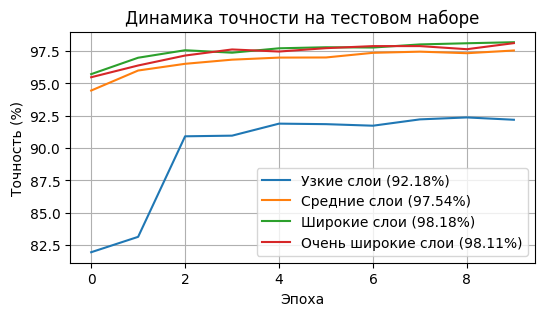

In [12]:
def print_summary(results):
    print("Результаты экспериментов:")
    print("{:<15} {:<20} {:<15} {:<15}".format(
        "Конфигурация", "Точность (%)", "Время (с)", "Параметры"))
    
    for name, data in results.items():
        print("{:<15} {:<20.2f} {:<15.2f} {:<15,}".format(
            name, data["accuracy"], data["time"], data["params"]))

print_summary(results)

# Визуализация обучения
plt.figure(figsize=(6, 3))
for name, data in results.items():
    plt.plot(data["test_acc_history"], label=f"{name} ({data['accuracy']:.2f}%)")

plt.title("Динамика точности на тестовом наборе")
plt.xlabel("Эпоха")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.savefig("plots/width_comparison.png")
plt.show()

## 2.2. Оптимизация архитектуры

### Создание архитектур для тестирования 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# Параметры для grid search
schemes = ['constant', 'decreasing', 'increasing']
layer_sizes = [64, 128]  # Размеры слоев
layer_counts = [3, 4]  # Количество слоев в модели

# Все полученные архитектуры
architectures = []

# Постоянная ширина
for size in layer_sizes:
    for count in layer_counts:
        architectures.append({
            'type': 'constant',
            'layers': [size] * count,
            'size': size,
            'count': count
        })

# Сужающаяся ширина
for start_size in layer_sizes:
    for count in layer_counts:
        layers = []
        current_size = start_size
        for i in range(count):
            layers.append(current_size)
            current_size = max(64, current_size // 2)  # Уменьшаем размер вдвое, но не меньше 64
        architectures.append({
            'type': 'decreasing',
            'layers': layers,
            'size': start_size,
            'count': count
        })

# Расширяющаяся ширина
for start_size in layer_sizes:
    for count in layer_counts:
        layers = []
        current_size = start_size
        for i in range(count):
            layers.append(current_size)
            current_size = current_size * 2  # Увеличиваем размер вдвое
        architectures.append({
            'type': 'increasing',
            'layers': layers,
            'size': start_size,
            'count': count
        })

### Создание модели NN

In [14]:
class BaseModelV2(nn.Module):
    def __init__(self, layer_widths):
        super().__init__()
        layers = []
        input_size = 784
        
        for width in layer_widths:
            layers.append(nn.Linear(input_size, width))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(width)) # Заменил dropout на batchnorm1d
            input_size = width
        
        layers.append(nn.Linear(input_size, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

def train_model(layer_sizes, epochs=15, batch_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform = v2.Compose([
        v2.ToTensor(),
        v2.Normalize((0.1307,), (0.3081,))
    ])
    
    train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)
    
    model = BaseModelV2(layer_sizes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    start_time = time.time()
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
    
    training_time = time.time() - start_time
    num_params = sum(p.numel() for p in model.parameters())
    
    return best_accuracy, training_time, num_params

### Grid Search

In [15]:
results = []

for architecture in tqdm(architectures, desc="Поиск лучшей архитектуры"):
    accuracy, time_taken, params = train_model(architecture['layers'])
    
    results.append({
        'type': architecture['type'],
        'size': architecture['size'],
        'count': architecture['count'],
        'accuracy': accuracy,
        'time': time_taken,
        'params': params,
        'layers': architecture['layers']
    })

results.sort(key=lambda x: x['accuracy'], reverse=True)

Поиск лучшей архитектуры: 100%|███████████████████████████████████████████████████████| 12/12 [56:47<00:00, 283.93s/it]


### Визуализация результатов


Топ 5 лучших архитектурs:
1. Тип: increasing, Количество слоев: 3, Базовый размер: 128
   Точность: 98.15%, Кол-во параметров модели: 272,010, Время обучения: 271.53сек
   Ширина слоев: [128, 256, 512]
2. Тип: decreasing, Количество слоев: 3, Базовый размер: 128
   Точность: 98.08%, Кол-во параметров модели: 114,058, Время обучения: 269.11сек
   Ширина слоев: [128, 64, 64]
3. Тип: constant, Количество слоев: 4, Базовый размер: 128
   Точность: 98.06%, Кол-во параметров модели: 152,330, Время обучения: 297.62сек
   Ширина слоев: [128, 128, 128, 128]
4. Тип: decreasing, Количество слоев: 4, Базовый размер: 64
   Точность: 98.05%, Кол-во параметров модели: 63,882, Время обучения: 303.10сек
   Ширина слоев: [64, 64, 64, 64]
5. Тип: constant, Количество слоев: 3, Базовый размер: 128
   Точность: 97.99%, Кол-во параметров модели: 135,562, Время обучения: 293.81сек
   Ширина слоев: [128, 128, 128]


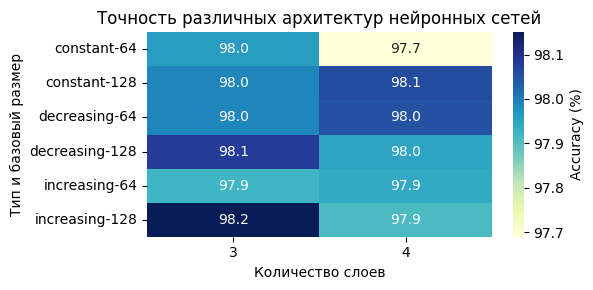

In [19]:
import pandas as pd

print("\nТоп 5 лучших архитектурs:")
for i, res in enumerate(results[:5]):
    print(f"{i+1}. Тип: {res['type']}, Количество слоев: {res['count']}, Базовый размер: {res['size']}")
    print(f"   Точность: {res['accuracy']:.2f}%, Кол-во параметров модели: {res['params']:,}, Время обучения: {res['time']:.2f}сек")
    print(f"   Ширина слоев: {res['layers']}")

# DataFrame для heatmap
heatmap_data = []
for res in results:
    heatmap_data.append({
        'Type': res['type'],
        'Layers': res['count'],
        'Size': res['size'],
        'Accuracy': res['accuracy']
    })

df = pd.DataFrame(heatmap_data)

# Визуализация heatmap
pivot_table = df.pivot_table(values='Accuracy', index=['Type', 'Size'], columns='Layers')
plt.figure(figsize=(6, 3))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Accuracy (%)'})
plt.title('Точность различных архитектур нейронных сетей')
plt.xlabel('Количество слоев')
plt.ylabel('Тип и базовый размер')
plt.tight_layout()
plt.savefig('architecture_heatmap.png', dpi=300)
plt.show()